In [1]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt

In [2]:
def plot_cum_fdr(targets, decoys, names=['Target', "Decoy"], title='', which='', frag_model=''):
    import matplotlib as mpl

    plt.style.use(['ieee', "high-vis", 'no-latex'])
    plt.rcParams["font.family"] = "DejaVu Sans"


    fig, ax = plt.subplots()    
    t_value = np.abs(targets)
    d_value = np.abs(decoys)
    
    t_v, t_base = np.histogram(t_value, bins=1000)
    d_v, d_base = np.histogram(d_value, bins=1000)

    t_cum_sum = np.cumsum(t_v[::-1])[::-1]/len(t_value)
    d_cum_sum = np.cumsum(d_v[::-1])[::-1]/len(d_value)

    ax.invert_xaxis()
    print(t_base.shape)
    print(d_base.shape)
    plt.plot(t_base[:-1], t_cum_sum, label=names[0])
    plt.plot(d_base[:-1], d_cum_sum, label=names[1])
    plt.legend(loc="upper left")
    plt.xlabel("Spectral Angle", fontsize=10)
    plt.ylabel("Cumulative Distribution", fontsize=10)
    plt.title(title, fontsize=10)
    
    fig.savefig(f"fig/fig3-cumulative-curve-{frag_model}-{which}.pdf",dpi=300, bbox_inches="tight")
    mpl.rcParams.update(mpl.rcParamsDefault)


In [3]:
def plot_cum_fdr_two(targets, decoys, targets_f, decoys_f, names=['Target', "Decoy"], which='', frag_model=''):
    import matplotlib as mpl

    plt.style.use(['ieee', "high-vis", 'no-latex'])
    plt.rcParams["font.family"] = "DejaVu Sans"

    fig, axs = plt.subplots(2, figsize=(4, 4))
    for i, ax in enumerate(axs):
        if i == 0:
            t_value = np.abs(targets)
            d_value = np.abs(decoys)
        else:
            t_value = np.abs(targets_f)
            d_value = np.abs(decoys_f)

        t_v, t_base = np.histogram(t_value, bins=1000)
        d_v, d_base = np.histogram(d_value, bins=1000)

        t_cum_sum = np.cumsum(t_v[::-1])[::-1] / len(t_value)
        d_cum_sum = np.cumsum(d_v[::-1])[::-1] / len(d_value)

        ax.invert_xaxis()
        print(t_base.shape)
        print(d_base.shape)
        ax.plot(t_base[:-1], t_cum_sum, label=names[0])
        ax.plot(d_base[:-1], d_cum_sum, label=names[1])
        
        if i == 0:
            ax.legend(loc="upper left")
        if i==1:
            ax.set_xlabel("Spectral Angle", fontsize=10)
        # ax.set_ylabel("Cumulative Distribution", fontsize=10)
        if i==0:
            ax.set_title("No Fine-tuned", fontsize=10)
        else:
            ax.set_title("Fine-tuned", fontsize=10)
    fig.text(-0.02, 0.5, 'Cumulative Distribution',
            va='center', rotation='vertical', fontsize=10)
    fig.tight_layout()
    fig.savefig(
        f"fig/fig3-cumulative-curve-{frag_model}-{which}.pdf", dpi=300, bbox_inches="tight")
    mpl.rcParams.update(mpl.rcParamsDefault)


In [4]:
import sys
sys.path.append("..")
from tools import *
import tools
from fdr_test import fixed_features_random
from ms import model, finetune
import ms
from ms.dataset import SemiDataset
from torch.utils.data import DataLoader

which = "chymo"
msms_file = f"/data/prosit/figs/fig235/{which}/maxquant/combined/txt/msms.txt"
raw_dir = f"/data/prosit/figs/fig235/{which}/raw"
fixed_features_dir = f"/data/prosit/figs/fig235/{which}/percolator_up/try/prosit_l1"

frag_model = "prosit_l1"
model_list = {
    "prosit_l1": model.PrositFrag,
    "pdeep2": model.pDeep2_nomod
}

checkpoints_list = {
    "prosit_l1": "/home/gus/Desktop/ms_pred/checkpoints/best/best_frag_l1_PrositFrag-1024.pth",
    "pdeep2": "/home/gus/Desktop/ms_pred/checkpoints/best/best_frag_l1_pDeep2-1024.pth"
}
run_model = model_list[frag_model]()
run_model.load_state_dict(torch.load(
    checkpoints_list[frag_model], map_location="cpu"))
prosit = run_model.eval()
tabels_file, random_matches = fixed_features_random(
    msms_file, raw_dir, fixed_features_dir)
print(tabels_file)

print(frag_model)
finetuned_prosit, _ = finetune.semisupervised_finetune(
    prosit, tabels_file, pearson=(frag_model == 'pdeep2'), enable_test=False)
name, msms_data = tools.read_msms(msms_file)
msms_data = tools.filter_msms(name, msms_data)


msms_data = msms_data[:100000]
msms_data.sort(key=lambda x: int(x[name.index("id")]))
m_r = loc_msms_in_raw(msms_data, raw_dir)

matched_ions_pre = generate_matched_ions(m_r)
m_i = [bio_helper.match_all(i, 'yb') for i in tqdm(matched_ions_pre)]
frag_msms = [bio_helper.reverse_annotation(*i[:4]) for i in tqdm(m_i)]


train_data = SemiDataset(tabels_file)
infer_loader = DataLoader(
    train_data.train_all_data(), batch_size=1024, shuffle=False)
test_infer_loader = DataLoader(
    train_data.test_all_data(), batch_size=1024, shuffle=False)

def get_test_score(dataset, loader, frag_model, model):
    device = torch.device("cuda:0")
    model = model.to(device)
    if_pearson = (frag_model == "pdeep2")
    with torch.no_grad():
        scores = []
        for i, data in enumerate(loader):
            data = {k: v.to(device) for k, v in data.items()}
            data["peptide_mask"] = helper.create_mask(
                data['sequence_integer'])
            pred = model(data)
            if not if_pearson:
                sas = helper.spectral_angle(
                    data['intensities_raw'], pred)
            else:
                sas = helper.pearson_coff(
                    data['intensities_raw'], pred)
            scores.append(sas.detach().cpu().numpy())
        scores = np.concatenate(scores, axis=0)
        # dataset.assign_test_score(scores)
        # test_q_values = train_data.Q_values_test()
        return scores

def get_train_score(dataset, loader, frag_model, model):
    device = torch.device("cuda:0")
    if_pearson = (frag_model == "pdeep2")
    model = model.to(device)
    with torch.no_grad():
        scores = []
        for i, data in enumerate(loader):
            data["peptide_mask"] = helper.create_mask(
                data['sequence_integer'])
            data = {k: v.to(device) for k, v in data.items()}
            pred = model(data)
            if not if_pearson:
                sas = helper.spectral_angle(
                    data['intensities_raw'], pred)
            else:
                sas = helper.pearson_coff(
                    data['intensities_raw'], pred)
            scores.append(sas.detach().cpu().numpy())
        scores = np.concatenate(scores, axis=0)
        dataset.assign_train_score(scores)
        test_q_values = train_data.Q_values()
        return scores


no_f_score_test = get_test_score(
    train_data, test_infer_loader, frag_model, prosit)
no_f_score_train = get_train_score(
    train_data, infer_loader, frag_model, prosit)

f_score_test = get_test_score(
    train_data, test_infer_loader, frag_model, finetuned_prosit)
f_score_train = get_train_score(
    train_data, infer_loader, frag_model, finetuned_prosit)
train_label = train_data._d['Label']
test_label = train_data._test_d['Label']
plot_cum_fdr_two(no_f_score_test[test_label == 1],
                 no_f_score_test[test_label == -1],
                 f_score_test[test_label == 1],
                 f_score_test[test_label == -1],
                 which=which, frag_model=frag_model)


/data/prosit/figs/fig235/chymo/maxquant/combined/txt/msms_random_peaks.txt False
Ions generating[random version]


  2%|▏         | 18036/921917 [00:12<11:01, 1367.03it/s]

/data/prosit/figs/fig235/trypsin/percolator_up/try/prosit_l1/fixed_features_shuffled.tab
prosit_l1
Run on cuda:0
Baseline Andromeda: 2 2 2
---------------
Achieve best: Train: 2 2 2
Achieve best: Train: 6 6 6
Train: 6 6 6
Train: 5 5 5
Train: 6 6 6
Achieve best: Train: 12 12 12
Achieve best: Train: 15 15 15
Achieve best: Train: 17 17 17
Train: 12 12 12
Achieve best: Train: 43 43 43


100%|██████████| 100000/100000 [00:03<00:00, 26755.62it/s]


(1001,)
(1001,)
(1001,)
(1001,)


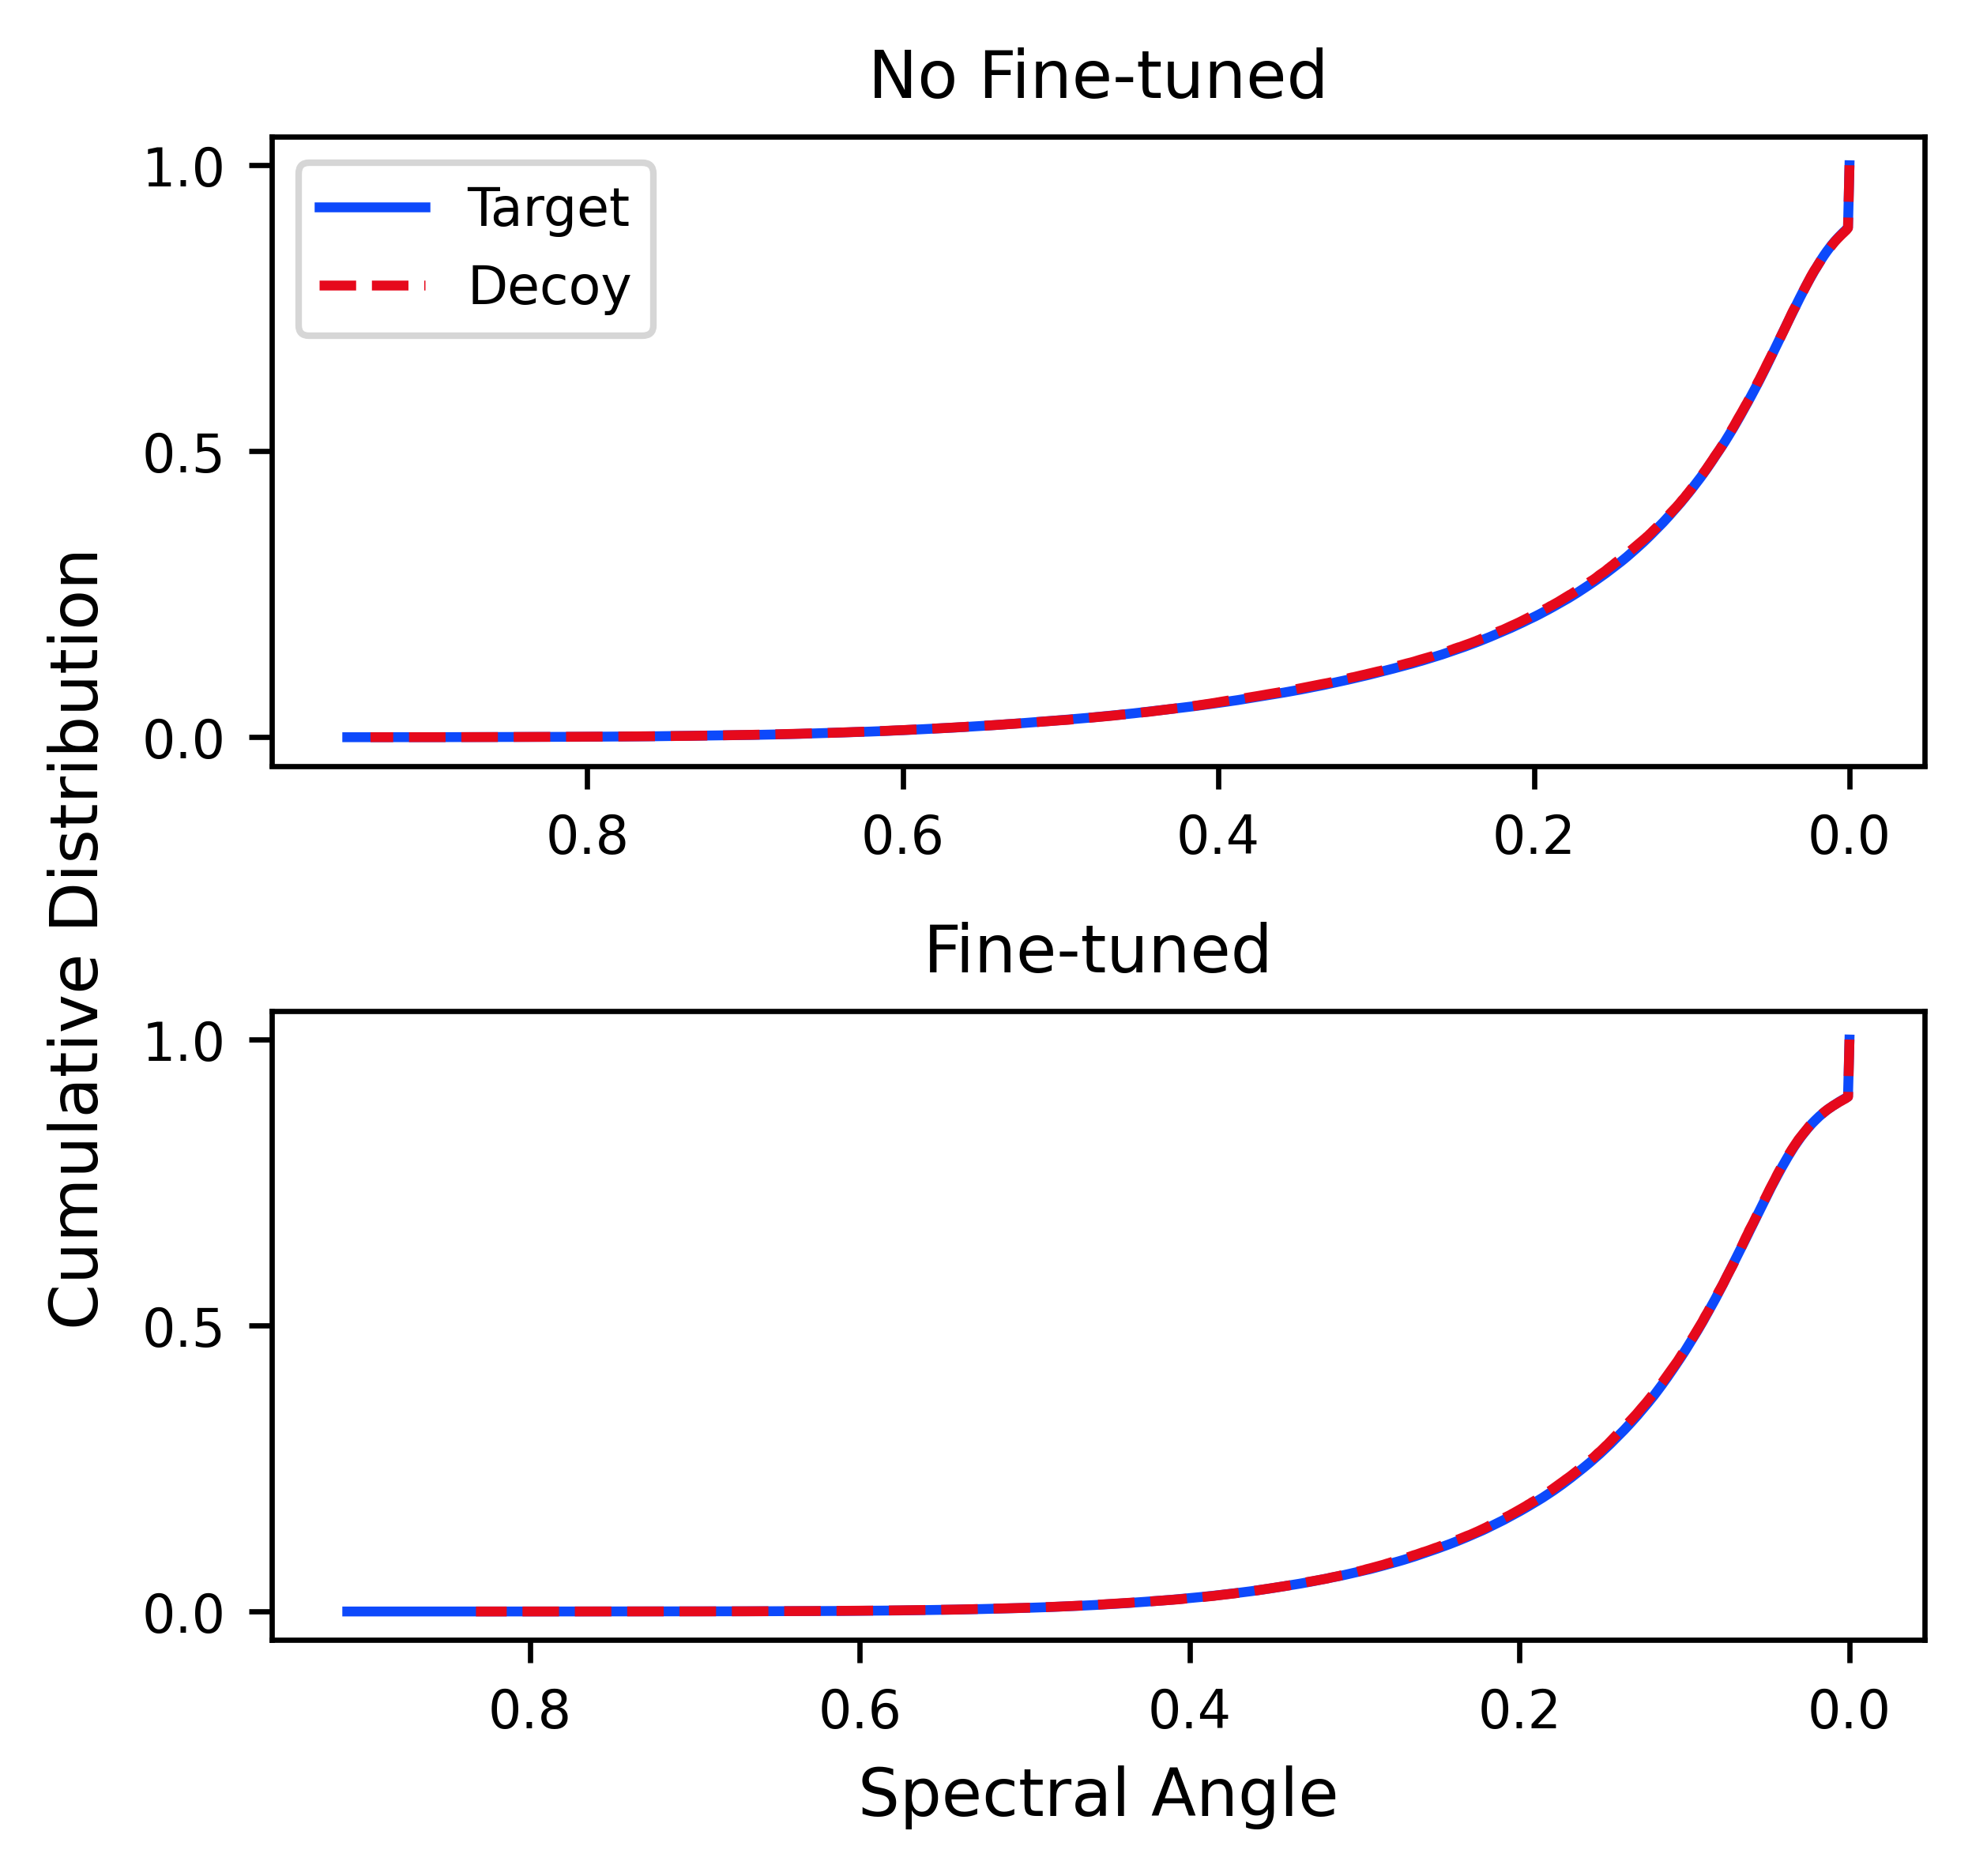

In [ ]:
plot_cum_fdr(f_score_test[test_label == 1], f_score_test[test_label == -1], title='Fine-tuned')

In [ ]:
frag_model = 'prosit_l1'

whichs = ['trypsin', 'gluc', "chymo", "lysc"]
data2plot = {}
for which in whichs:
    result_dir = f"/data/prosit/figs/fig235/{which}/percolator_up/try/{frag_model}"

    no_finetuned_dir = os.path.join(result_dir, "no_finetuned")

    sa = pd.read_csv(os.path.join(
        no_finetuned_dir, "sa.tab"), sep='\t')
    sa_feat = sa['spectral_angle'][sa['Label'] == 1]
    sa_feat_decoy = sa['spectral_angle'][sa['Label'] == -1]
    
    andro = pd.read_csv(os.path.join(
        no_finetuned_dir, "andromeda.tab"), sep='\t')
    andro_feat = andro['andromeda'][andro['Label'] == 1]
    andro_feat_decoy = andro['andromeda'][andro['Label'] == -1]

    data2plot[which] = {"score": (sa_feat, sa_feat_decoy), "andromeda": (andro_feat, andro_feat_decoy)}


In [ ]:
plot_cum_fdr(data2plot['chymo']['andromeda'][0],
             data2plot['chymo']['andromeda'][1])


In [ ]:
frag_model = 'prosit_l1'

whichs = ['trypsin', 'gluc', "chymo", "lysc"]
data2plot_f = {}
for which in whichs:
    result_dir = f"/data/prosit/figs/fig235/{which}/percolator_up/try/{frag_model}"

    no_finetuned_dir = os.path.join(result_dir, "finetuned")

    sa = pd.read_csv(os.path.join(
        no_finetuned_dir, "sa.tab"), sep='\t')
    sa_feat = sa['spectral_angle'][sa['Label'] == 1]
    sa_feat_decoy = sa['spectral_angle'][sa['Label'] == -1]

    andro = pd.read_csv(os.path.join(
        no_finetuned_dir, "andromeda.tab"), sep='\t')
    andro_feat = andro['andromeda'][andro['Label'] == 1]
    andro_feat_decoy = andro['andromeda'][andro['Label'] == -1]

    data2plot_f[which] = {"score": (sa_feat, sa_feat_decoy), "andromeda": (
        andro_feat, andro_feat_decoy)}


In [ ]:
plot_cum_fdr(data2plot_f['chymo']['score'][0],
             data2plot_f['chymo']['score'][1])
